<a href="https://colab.research.google.com/github/Tanulshn/Python-and-DS-work/blob/main/ARIMA_TSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Basic Package
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# Warnings 
import warnings
warnings.simplefilter(action='ignore')


### Data Preprocessing

In [2]:
# Read the data
raw_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Time Series Analysis/Banks/HDFC Bank/2 yr TSA.csv')
raw_data.head(20)

,Date,Value,Price
0,6/1/2019,No Data FOund,No Data FOund
1,6/2/2019,No Data FOund,No Data FOund
2,6/3/2019,31.80974372,1228.55
3,6/4/2019,31.74760267,1226.15
4,6/5/2019,No Data FOund,No Data FOund
5,6/6/2019,31.37281447,1211.675
6,6/7/2019,31.68740353,1223.825
7,6/8/2019,No Data FOund,No Data FOund
8,6/9/2019,No Data FOund,No Data FOund
9,6/10/2019,31.59095544,1220.1


In [23]:
df=raw_data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    731 non-null    object
 1   Value   731 non-null    object
 2   Price   731 non-null    object
dtypes: object(3)
memory usage: 17.3+ KB


In [24]:
# Change the dtype
for i in (['Value','Price']):
  df[i]=pd.to_numeric(raw_data[i], errors= 'coerce').round(2)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    731 non-null    object 
 1   Value   494 non-null    float64
 2   Price   494 non-null    float64
dtypes: float64(2), object(1)
memory usage: 17.3+ KB


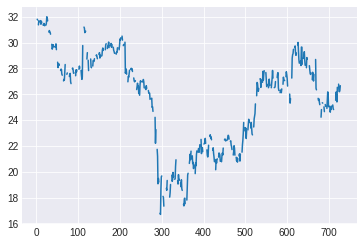

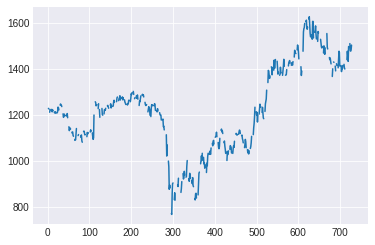

In [25]:
df['Value'].plot()
plt.show()
df['Price'].plot()

In [26]:
df.corr()

,Value,Price
Value,1.000000,0.673561
Price,0.673561,1.000000


#### Date-time formatting

In [27]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst = False)
df.set_index('Date', inplace=True)
df.isnull().sum()

Value    237
Price    237
dtype: int64

In [59]:
# Business days time series
data = df.resample('b').last()
data.isnull().sum()

Value    31
Price    31
dtype: int64

In [60]:
data.fillna(method='bfill', inplace=True)

In [61]:
data.isnull().sum()

Value    0
Price    0
dtype: int64

In [62]:
data.shape

(522, 2)

## Test for Stationarity

In [63]:
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.stattools import adfuller

In [64]:
# Define a function for Stationarity check

def adfuller_test(series):
  """ Takes the series and tests whether the series is stationary or not 
  by using ADFULLER test.
  """
  result = adfuller(series)
  labels = ['ADF Test stat', 'p-value', '# Lags', '# observations']
  for value, label in zip(result,labels):
    print(label, ': ', str(value))

  if result[1]<=0.05:
    print('Outcome: Strong evidence against the null hypothesis; reject H0; data has no unit root; DATA IS STATIONARY.')
  else:
    print('Outcome: Weak evidence against H0; accept H0, DATA IS NOT STATIONARY') 


In [65]:
adfuller_test(data['Price'])

ADF Test stat :  -0.9667821344274781
p-value :  0.7651861831579707
# Lags :  4
# observations :  517
Outcome: Weak evidence against H0; accept H0, DATA IS NOT STATIONARY


Conclusion: The Data is not stationary
We need to induce stationarity to be able to perform forecast through ARIMA

### Induce Stationarity

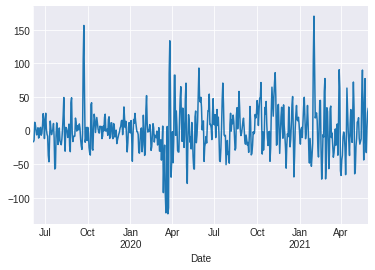

In [100]:
# First degree differencing
stationary_series = data['Price'].diff(2).dropna()
stationary_series.plot()

In [101]:
# Check for stationarity
adfuller_test(stationary_series)

ADF Test stat :  -5.325418291390569
p-value :  4.8494182646194105e-06
# Lags :  14
# observations :  504
Outcome: Strong evidence against the null hypothesis; reject H0; data has no unit root; DATA IS STATIONARY.


Now that the snew series is stationary, we can plot ACF and PACF to determine the p and q variables for ARIMA

## Autocorrelation check

In [91]:
# Create train set
train_size = int(len(data)*0.7)
train_size

364

In [92]:
import statsmodels.graphics.tsaplots as sgt

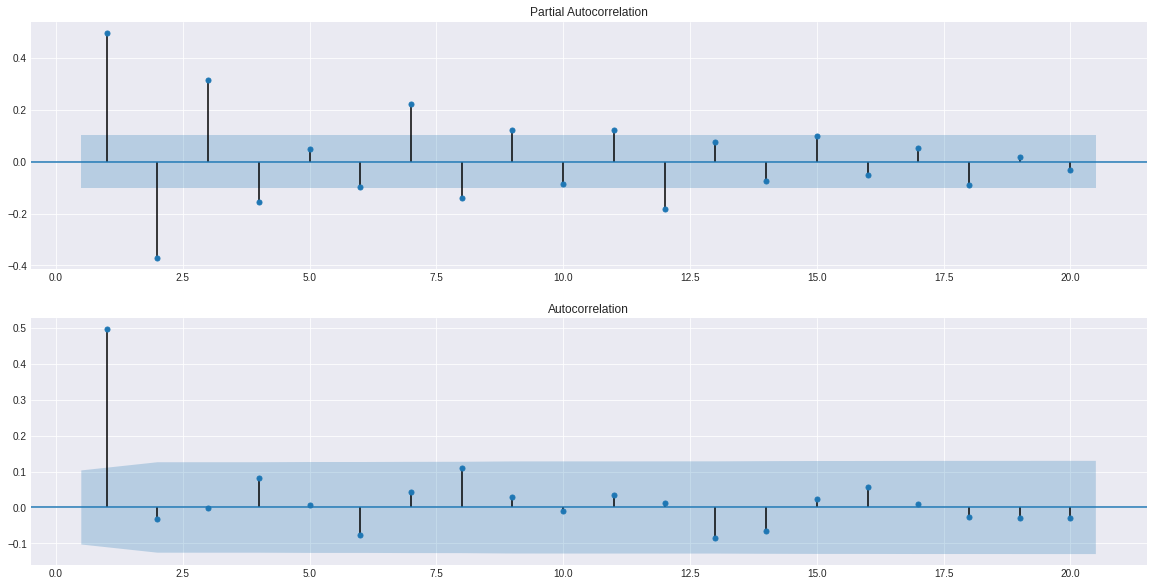

In [102]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(211)
fig = sgt.plot_pacf(data['Price'][:train_size].diff(2).dropna(), lags=20, ax=ax1,zero= False)

ax2 = fig.add_subplot(212)
fig = sgt.plot_acf(data['Price'][:train_size].diff(2).dropna(), lags=20, ax=ax2, zero= False)



Conclusion:

Value of p: No of lags for AR (PACF Plot): 6

Value of q: No of lags for MA (ACF Plot):  6


## ARIMA model

In [73]:
# Import package
from statsmodels.tsa.arima_model import ARIMA

In [118]:
# Define a function to call:

def predict_ARIMA(train_data):
  """ The fun will fit ARIMA on the train data and forecast
  """
  model = ARIMA(train_data, order=(2,2,1))
  
  # Fit the model
  try:
    model_fit = model.fit(disp=0)
    #Forecast
    forecast = model_fit.forecast() 
    return forecast[0][0]
  except:
    pass

In [117]:
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)

# Find the params
model = ARIMA(data['Price'][:train_size], order=(2, 2, 1))
model_fit_0 = model.fit()
print(model_fit_0.params.round(2))

const             0.01
ar.L1.D2.Price    0.02
ar.L2.D2.Price   -0.03
ma.L1.D2.Price   -1.00
dtype: float64


In [123]:
data['Pred'] = data['Price'].rolling(train_size).apply(predict_ARIMA).round(2)
data['Pred'] = data['Pred'].shift(1)

In [122]:
data.tail()

,Value,Price,Stn_P,Pred
Date,,,,
2021-05-25,26.23,1478.95,-31.0,1511.23
2021-05-26,26.19,1477.05,-1.9,1480.52
2021-05-27,26.29,1482.65,5.6,1481.50
2021-05-28,26.66,1503.45,20.8,1485.90
2021-05-31,26.88,1515.85,12.4,1507.19
